# "Предсказание стоимости авто"

# Описание проекта

**Дано** - исторические данные по объявлением о продаже автомобилей; <br/>


**Задача** - разработать оценщик стоимости автомобилей с использованием лучшей модели по метрике RMSE. Также важными параметрами являеются скорость обучения и предсказания.<br/>

Сравнивать будем модели:<br/>
- Дерева решений;
- Случайный лес;
- Классический бустинг Light GBM.

## Шаг 1 - Чтение и загрузка данных

На данном шаге загрузим необходимые бибилотеки, настроим блокнот и загрузим данные.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

In [32]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [33]:
from catboost import CatBoostRegressor
from catboost import cv, Pool

In [3]:
# настроим тёмную тему для графиков 
plt.style.use('dark_background')

# отключим предупреждения matplotlib 
import warnings
warnings.filterwarnings('ignore')

In [4]:
# чтение данных
df = pd.read_csv('/content/drive/MyDrive/Data Science/Проекты/3 модуль/Проект 2_Численные методы/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Бибилотеки и данные загружены успешно. Приступим к EDA.

## Шаг 2 - EDA

На данном шаге проведём разведовательный анализ данных. Будем только смотреть, изменять данные не будем.

In [5]:
# размерность датасета
df.shape

(354369, 16)

Датасет достаточно большой

In [6]:
# общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
# общая инофрмация
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Из данных видим следующие особенности: есть цена равная 0, год регистрации 1000 и 9999, мощность 0 л.с. и 20000 л.с., нулевой месяц регистрации, нулевое количесвто фото (бесполезный столбец). <br/>

Данные особенности являются аномалиями, о которых необходимо помнить. Менять или преобразовывать данные в этом плане не будем - будем работать с реальными данными - такими какие есть.

In [8]:
# пропуски
df.isna().mean().sort_values(ascending = False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

В датасете в некоторых столбцах имеется до 20% пропусков. С ними будет необходимо провести работу. 

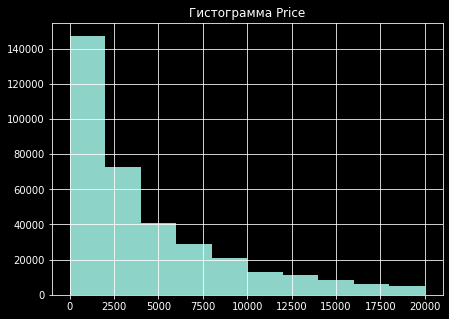

In [10]:
# гистограмма Price
plt.title('Гистограмма Price')
df['Price'].hist(figsize=(7,5));

In [11]:
# количество авто по оцень малой цене
print("Количество объявлений с аномально низкой ценой:")
df['Price'][df['Price'] < 100].count()

Количество объявлений с аномально низкой ценой:


13314

Целевой признак не имеет выбросов вправо, хотя имеет очень малое значение. В дальнейшем целесообразно их удалить

**Выводы по результатам EDA:**<br/>
- имеем датасет размерностью (354369, 16);
- в датасете есть аномалии. Для достижения максимального качества моделей от таких данных лучше избавиться, но для правдоподобности с аномалиями ничего делать не будем;
- есть как численные, так и категориальные признаки. Категориальные будет необходимо преобразовать при помощи кодирования;
- имеем от 5%  до 20% пропусков. Работа с ними будет проведена на следующих этапах.

На следующем шаге проведём предобработку данных - выделим тестовую выборку для проверки, проведём работу с пропусками, сделаем кодирование.

## Шаг 3 - Подготовка и предобработка данных

На данном шаге подготовим данные для моделей

### Удаление ненужных столбцов

Удалим столбцы, которые содержат данные времени, потому как они не несут пользу для моделей, а так же столбец `NumberOfPictures` так как он пустой

In [12]:
# удаление столбцов
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'], axis = 1)

In [13]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


Столбцы удалены успешно

### Заполнение пропусков и работа с аномалиями

В столбце `NotRepaired`	пропуски заменим "заглушкой", потому как удалять строки с пропусками в этом столбце нецелесообразно - из порядка 20%, а достоврено заполнить у нас нет возможности.

In [14]:
# Заполнение пропусков заглушкой 'not_info'
df['NotRepaired'] = df['NotRepaired'].fillna('not_info')

# проверка заполнения
df['NotRepaired'].unique()

array(['not_info', 'yes', 'no'], dtype=object)

Колонку модель так же не представляется заполнить должным образом. Поставим "Заглушку".

In [15]:
# Заполнение пропусков заглушкой 'not_info'
df['Model'] = df['Model'].fillna('not_info')

# проверка заполнения
df['Model'].isna().sum()

0

Заполнение пропусков прошло успешно 

Нужно удалить нулевые значения цены и мощности. Также можно задать диапазон по минимальным и максимальным значениям цены и мощности.
    
Есть аномалии в годе регистрации авто. Год регистрации не может превышать дату скачивания анкеты (2016 год), а также желательно ограничить минимальное значение года на уровне 1950-60 годов.
    
Рекомендуется удалить колонку с почтовым индексов. Можно конечно индекс перевести в название региона и сделать как категориальную переменную.


Отфильтруем объявления по мощности. Зададим нижнюю границу в 20 л.с., а верхнюю в 500 л.с.

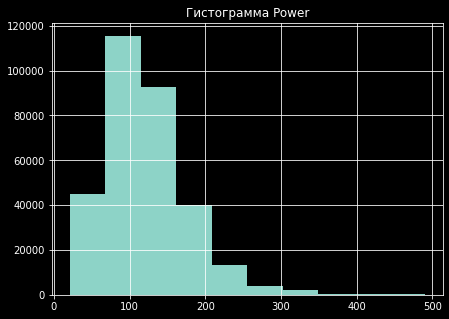

In [16]:
# отфильтруем объявления по мощности
df = df[(df['Power'] < 500) & (df['Power'] > 20)]

# гистограмма по мощности 
plt.title('Гистограмма Power')
df['Power'].hist(figsize=(7,5));

Фильтрация по мощности прошло успешно

Отфильтруем значения по цене

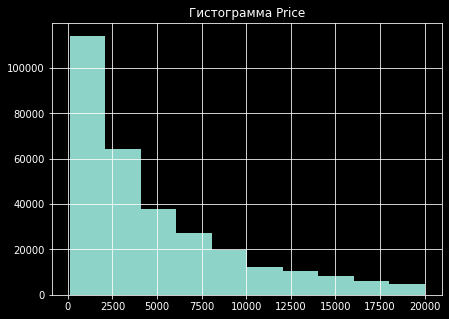

In [17]:
# отфильтруем объявления по цене
df = df[df['Price'] > 100]

# гистограмма по цене 
plt.title('Гистограмма Price')
df['Price'].hist(figsize=(7,5));

Фильтрация по цене прошла успешно

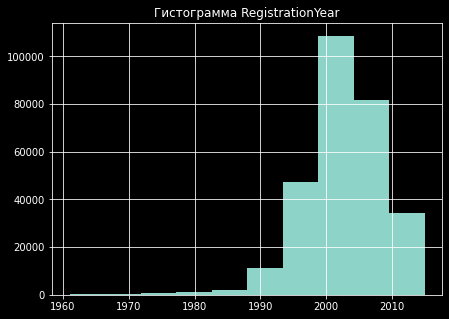

In [18]:
# отфильтруем объявления по году
df = df[(df['RegistrationYear'] > 1960) &  (df['RegistrationYear'] < 2016)]

# гистограмма по году 
plt.title('Гистограмма RegistrationYear')
df['RegistrationYear'].hist(figsize=(7,5));

Фильтрация по году прошла успешно

Удаление колонок

In [19]:
# удалим колонку с почтовым индексом
df = df.drop(['PostalCode', 'RegistrationMonth'], axis = 1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,not_info,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,not_info
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Удаление столбца прошло успешно

Провекра на дубликаты

In [20]:
# проверка на дубликаты 
df.duplicated().sum()

38633

Удаление дубликатов

In [21]:
# удаление дубликатов
df = df.drop_duplicates(ignore_index = True)
df.duplicated().sum()

0

Удаление дубликатов прошло успешно

### Разделение на train и test

Разделим данные на тренировочную и тестовую выборки. Тестовую "отложим в сторонку", как будто эта часть данных нам неизвестна.

In [22]:
# обозначим фичи и таргет
X = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 
     'Model', 'Kilometer', 'FuelType', 
     'Brand', 'NotRepaired']
       
y = ['Price']

In [23]:
# разделим на train и test
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], 
                                                    train_size=0.8, 
                                                    test_size=0.2, 
                                                    random_state=1)

In [24]:
# проверка правильности разделения
#  в результате должно быть 0.8
len(X_train) / (len(X_train) + len(X_test))

0.7999967901264289

Разделение прошло успешно

### Заполнение пропусков_2

Создадим класс для заполнения пропусков самым частым значением (most frequent)

In [25]:
from sklearn.base import TransformerMixin

class SeriesImputer(TransformerMixin):

    def __init__(self):
        """Заполняет пропуски самым часто встречающимся значением"""

    def fit(self, X, y=None):
        if X.dtype == np.dtype('O'): 
            self.fill = X.value_counts().index[0]
        
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)

Заполним пропуски

In [26]:
# столбец 'VehicleType'
imputer_vt = SeriesImputer()
imputer_vt.fit(X_train['VehicleType'])

X_train['VehicleType'] = imputer_vt.transform(X_train['VehicleType'])
X_test['VehicleType'] = imputer_vt.transform(X_test['VehicleType'])

In [27]:
# столбец 'FuelType'
imputer_ft = SeriesImputer()
imputer_ft.fit(X_train['FuelType'])

X_train['FuelType'] = imputer_ft.transform(X_train['FuelType'])
X_test['FuelType'] = imputer_ft.transform(X_test['FuelType'])

In [28]:
# столбец 'Gearbox'
imputer_gb = SeriesImputer()
imputer_gb.fit(X_train['Gearbox'])

X_train['Gearbox'] = imputer_gb.transform(X_train['Gearbox'])
X_test['Gearbox'] = imputer_gb.transform(X_test['Gearbox'])

Проверим заполнение пропусков

In [29]:
# выведем колмчесвто прпоусков на экран
print("Пропуски в X_train:", X_train.isna().sum().sum())
print("Пропуски в X_test:", X_test.isna().sum().sum())

Пропуски в X_train: 0
Пропуски в X_test: 0


Заполнение пропусков прошло успешно

### Кодирование категориальных переменных

Ввиду того как мы используем модели деревьев, будем использовать `OrdinalEncoder`

In [30]:
# объявим список категориальных столбцов
object_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [31]:
# проведём кодирование
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# создадим копию сетов
X_train_code = X_train.copy()
X_test_code = X_test.copy()

X_train_code[object_cols] = ordinal_encoder.fit_transform(X_train_code[object_cols])
X_test_code[object_cols] = ordinal_encoder.transform(X_test_code[object_cols])

Кодирование проведено успешно

### Выводы по Шагу 3

На данном шаге: <br/>
- удалили столбцы, которые не понадобятся в обучении;
- разделили на тренировочную и тестовую выборки;
- заполнили пропуски путем "заглушек" и наиболее частых значений;
- провели кодирвоание категориальных переменных.

На следующем шаге обучим модели и подберём оптимальные гиперпараметры

## Шаг 4 - Обучение моделей

### Дерево решений

На кросс-валидации подберём лучший параметр

In [34]:
%%time
model_tr = DecisionTreeRegressor(random_state = 1)

parametrs = {'max_depth': range (1,15,2)}  

grid = GridSearchCV(model_tr, parametrs, cv=5, n_jobs=-1)

grid.fit(X_train_code, y_train)

best_tr = grid.best_params_
best_tr 

CPU times: user 747 ms, sys: 53.5 ms, total: 801 ms
Wall time: 9.63 s


Обучим модель и посчитаем метрику RMSE

In [35]:
%time
model_tr = DecisionTreeRegressor(random_state = 1, 
                                 max_depth = best_tr['max_depth'])

model_tr.fit(X_train_code, y_train)
result_tr = model_tr.predict(X_test_code)
mean_squared_error(y_test, result_tr, squared=False)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


1832.7509976503784

### Случайный лес

Кросс-валидация на случайном лесе занимает очень много времени. Поэтому примем глубину дерева равной 13, а количесвто n_estimators оставим дефолтным.

In [36]:
%%time
model_fr = RandomForestRegressor(random_state = 1, n_estimators=100, max_depth=13)
model_fr.fit(X_train_code, y_train)
result_fr = model_fr.predict(X_test_code)


CPU times: user 35.4 s, sys: 4.49 ms, total: 35.4 s
Wall time: 36.7 s


In [37]:
# RMSE на test для случайного леса
(y_test, result_fr, squared=False)

1665.4860273476183

### Light GBM

In [ ]:
# кодирование категориальных фичей
X_train[object_cols] = X_train[object_cols].astype('category')
X_test[object_cols] = X_test[object_cols].astype('category')

Обучим модель LightGBM

In [ ]:
%%time
train_dataset = lgb.Dataset(X_train, y_train, feature_name=X)
valid_dataset = lgb.Dataset(X_test,  y_test, feature_name=X)

booster = lgb.train({"objective": "regression"},
                    train_set=train_dataset, valid_sets=(valid_dataset,),
                    num_boost_round=100)

In [ ]:
# предсказание и расчёт метрики RMSE
test_preds = booster.predict(X_test)
mean_squared_error(y_test, test_preds, squared=False)

1575.271281226678

### CatBoost

In [38]:
# создание Pool
train_data = Pool (data = X_train_code,
                   label = y_train)

Эмпирически подобрали такой learning_rate, при котором точка переробучения случается ближе к 1000 итераций на кросс-валдиации (982 итерации)

In [39]:
# Словарь параметров 
params = {'eval_metric' : 'RMSE',
          'iterations' : 982,
          'loss_function':'RMSE',
          'learning_rate' : 0.37,
          'random_seed' : 1,
          'verbose' : 100}

In [40]:
# кросс-валидация
cv_data = cv(
                params = params,
                pool=train_data,  
                fold_count=5,
                shuffle=True,
                partition_random_seed=0,
                verbose=False,
                early_stopping_rounds=200
            )

Training on fold [0/5]

bestTest = 1578.456031
bestIteration = 977

Training on fold [1/5]

bestTest = 1562.111659
bestIteration = 879

Training on fold [2/5]

bestTest = 1573.778025
bestIteration = 919

Training on fold [3/5]

bestTest = 1587.946794
bestIteration = 925

Training on fold [4/5]

bestTest = 1587.892737
bestIteration = 975



In [41]:
#  датасет после кросс-валидации
cv_data
min_rmse=cv_data['test-RMSE-mean'].min()
cv_data[cv_data['test-RMSE-mean'] == min_rmse]

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
978,978,1578.320143,10.702457,1372.562117,1.718191


In [42]:
# создание модели с учетом CV
model_cv=CatBoostRegressor(**params)

In [ ]:
#model_cv.fit(train_data, use_best_model=True, eval_set=(X_test_code, y_test))

In [43]:
# обучение модели 
model_cv.fit(train_data)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 3565.7951976	total: 43.9ms	remaining: 43s
100:	learn: 1625.7559167	total: 3.07s	remaining: 26.8s
200:	learn: 1554.3999876	total: 4.94s	remaining: 19.2s
300:	learn: 1513.1789717	total: 6.81s	remaining: 15.4s
400:	learn: 1485.0100381	total: 8.65s	remaining: 12.5s
500:	learn: 1461.6911886	total: 11s	remaining: 10.6s
600:	learn: 1442.4843450	total: 14s	remaining: 8.85s
700:	learn: 1426.8619411	total: 16.8s	remaining: 6.75s
800:	learn: 1413.8587211	total: 18.7s	remaining: 4.23s
900:	learn: 1400.3035390	total: 20.6s	remaining: 1.85s
981:	learn: 1390.7841216	total: 22.1s	remaining: 0us


In [45]:
# предсказание 
result_catboost=model_cv.predict(X_test_code)

# RMSE с использованием параметров полученных на кросс-валидации 
mean_squared_error(y_test, result_catboost, squared=False)

1551.0659126270841

### Выводы по Шагу 4

На данном шаге были обучены модели дерева решений, случайного леса и LightGBM, CatBoost, расчитана метрика RMSE. 

На следующем шаге сравним модели

## Сравнение моделей

На данном шаге проведём сравнение моеделей по важным для заказчика метрикам

In [46]:
# создадим датасет для сравнения
final = pd.DataFrame({'RMSE' : [1832, 1665, 1575, 1551]},
                     index = ['Tree', 'Forest', 'LightGBM', 'Catboost'])
final

,RMSE
Tree,1832
Forest,1665
LightGBM,1575
Catboost,1551


Из таблицы видим: <br/>
- что у дерева решений самый низкий скор. 
- у случайного леса скор лучше чем у дерева, но и меньше чем у бустинга;
- наилучший скор у бустинга, причём CatBoost на кросс-валидации показал себя лучше чем LightGBM.

## Выводы

В данном проекте было проведено срвнение трёх моделе машинного обучекния на основе дерева решений для предсказания цены на автомобили. Критерием сравнения был скор и время обучения и предсказания. 

Для заказчика я бы порекомендовал модель бустинга, так как у неё самый лучший скор